In [1]:
import time
import random
import tensorflow as tf
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, Concatenate, AveragePooling2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras import losses
from tensorflow.keras import metrics 
from matplotlib import pyplot
from tensorflow.python.autograph.pyct import transformer



In [4]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g =  BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.4)(g, training=True)
    g = Concatenate()([g, skip_in])
    g = ReLU()(g)
    return g



In [5]:
def defing_generator(latent_size, image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    content_image = Input(shape=image_shape)
    style_image = Input(shape=image_shape)
    # stack content and style images
    stacked_layer = Concatenate()([content_image, style_image])
    #encoder model
    e1 = define_encoder_block(stacked_layer, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    #e7 = define_encoder_block(e6, 512)
    # bottleneck layer
    b = Conv2D(latent_size, (4, 4), strides=(2, 2), padding='same', kernel_constraint=init)(e6)
    b = ReLU()(b)
    #decoder model
    #d1 = define_decoder_block(b, e7, 512)
    d2 = define_decoder_block(b, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    #ouutput layer
    g = Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(inputs=[content_image, style_image], outputs=out_image, name='generator')
    return model


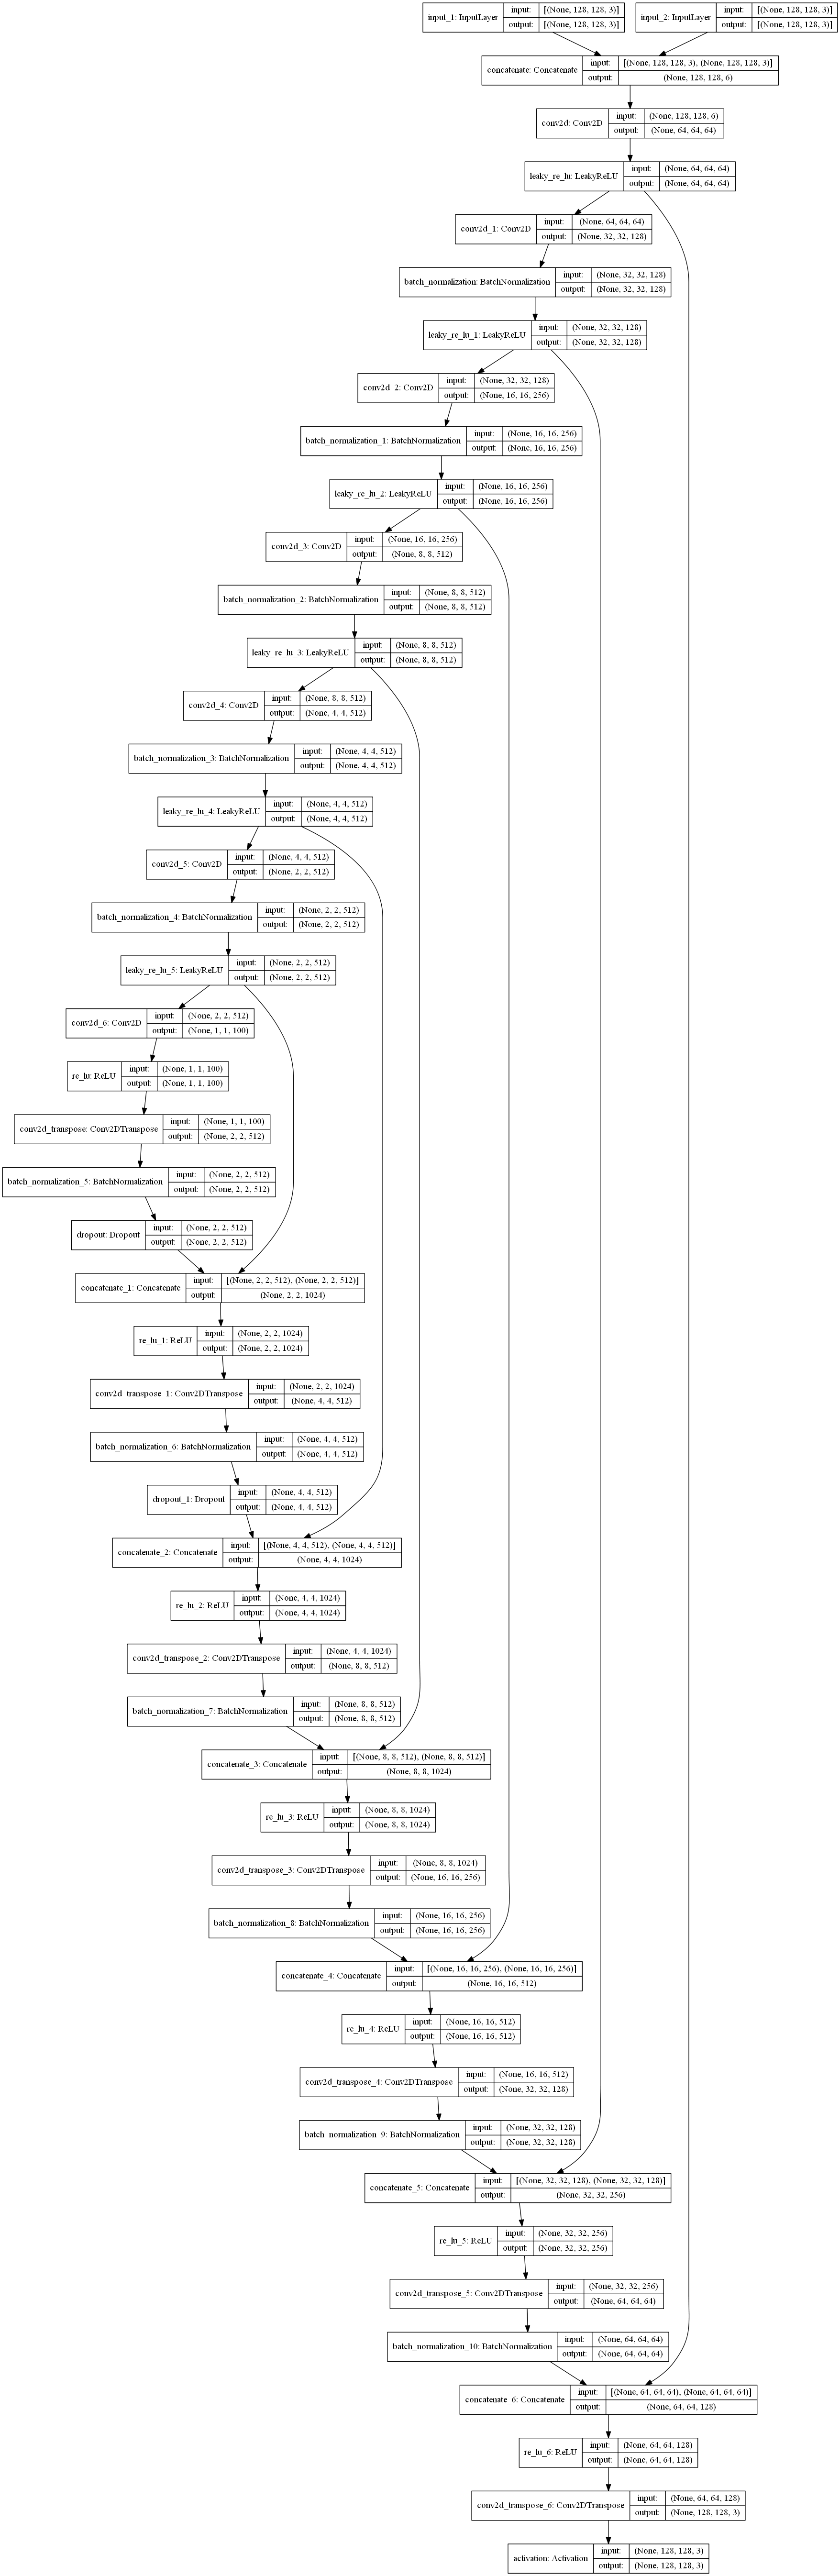

In [6]:

g_model = defing_generator(100)
tf.keras.utils.plot_model(g_model, show_shapes=True)


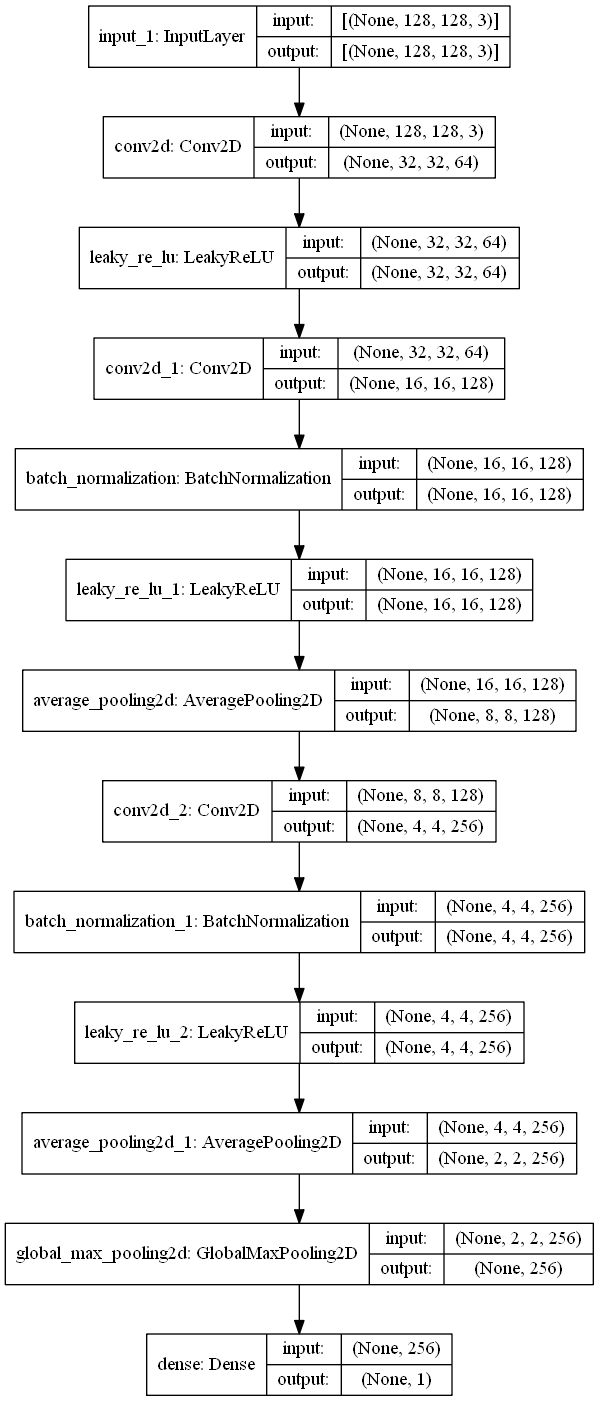

In [2]:
def define_style_descrminator(image_size=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    input_img = Input(shape=image_size)
    # C64
    d = Conv2D(64, (4, 4), (4, 4), padding='SAME', kernel_initializer=init)(input_img)
    d = LeakyReLU(alpha=0.2)(d)
	# C128
    d = Conv2D(128, (4, 4), (2, 2), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
	# C256
    d = Conv2D(256, (4, 4), (2, 2), padding='SAME', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = AveragePooling2D()(d)
    # flatten
    flt = GlobalMaxPool2D()(d)
    # linear logits layer
    output = Dense(1)(flt)
    #build and compile the model
    model = Model(inputs=input_img, outputs=output, name='style_descriminator')
    return model

dss_model = define_style_descrminator()
tf.keras.utils.plot_model(dss_model, show_shapes=True)


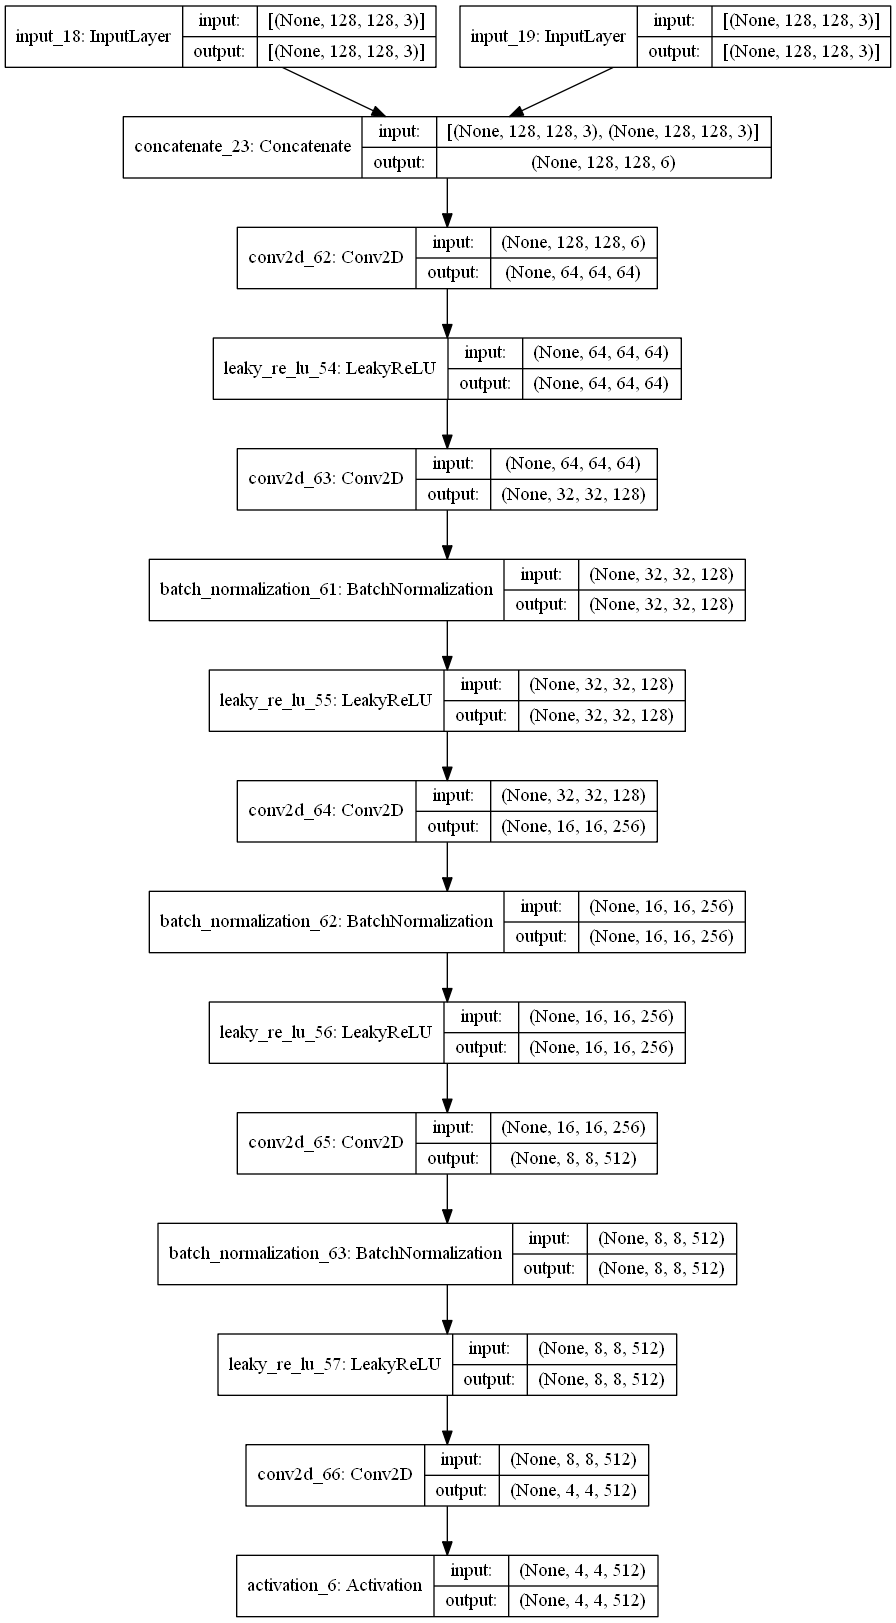

In [29]:
def define_cnt_descriminator(image_shape=(128, 128, 3)):
    init = RandomNormal(stddev=0.02)
    #content image input
    in_cnt_image = Input(shape=image_shape)
    #transfer image input 
    in_tr_image = Input(shape=image_shape)
    #concatnate image channel-wise
    merged = Concatenate()([in_cnt_image, in_tr_image])
    # c64
    d = Conv2D(64, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # c128
    d = Conv2D(128, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c256
    d = Conv2D(256, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # c512
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(512, (4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    #define model
    model = Model(inputs=[in_cnt_image, in_tr_image], outputs=patch_out, name='content_descriminator')
    return model

dsc_model = define_cnt_descriminator()
tf.keras.utils.plot_model(dsc_model, show_shapes=True)


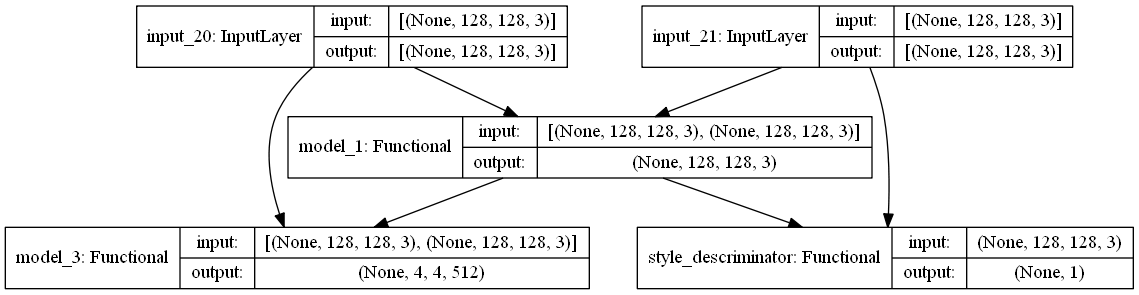

In [32]:
def define_gan(g_model, dc_model, ds_model, image_shape=(128, 128, 3)):
    for layer in dc_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    
    for layer in ds_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # input layer for GAN model
    cnt_img = Input(shape=image_shape)
    style_img = Input(shape=image_shape)
    # generator model
    gen_out = g_model([cnt_img, style_img])
    # style descriminator model
    dss_out = ds_model(style_img)
    dst_out = ds_model(gen_out)
    # content descriminator model
    cnt_out = dc_model([cnt_img, gen_out])
    model = Model(inputs=[cnt_img, style_img], outputs=[gen_out,  dss_out, dst_out, cnt_out])
    return model

gan_model = define_gan(g_model, dsc_model, dss_model)
tf.keras.utils.plot_model(gan_model, show_shapes=True)


In [17]:
def define_style_descrminator(output_size,image_shape):
    vgg16_feature_net = tf.keras.applications.VGG16(include_top=False, input_shape=image_shape)
    for layer in vgg16_feature_net.layers:
        layer.trainable = False
    feature_map = vgg16_feature_net.output
    x = GlobalMaxPool2D()(feature_map)
    x = Dropout(rate=0.5)(x)
    x = Dense(512, activation='relu')(x)
    logits = Dense(output_size, use_bias=False)(x)
    model = Model(inputs=vgg16_feature_net.input, outputs=logits)
    return model

In [18]:
dss_model = define_style_descrminator(64, (128, 128, 3))
dss_model.summary()
#tf.keras.utils.plot_model(dss_model, show_shapes=True)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [29]:
class StyleNet(tf.keras.Model):

    def __init__(self, base_model):
        super(StyleNet, self).__init__()
        self._model = base_model 

    @tf.function
    def call(self, inputs):
        ref_img, trans_img = inputs
        with tf.name_scope("Style") as scope:
            ft1 = self._model(ref_img)
            ft1 = tf.math.l2_normalize(ft1, axis=-1)
        with tf.name_scope("Transfer") as scope:
            ft2 = self._model(trans_img)
            ft2 = tf.math.l2_normalize(ft2, axis=-1)
        return [ft1, ft2]
    
    @tf.function
    def get_features(self, inputs):
        return tf.math.l2_normalize(self._model(inputs), axis=-1)


In [32]:
model = StyleNet(dss_model)
#model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [31]:
out = model([tf.zeros((32, 128, 128, 3)), tf.zeros((32, 128, 128, 3))])

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Style/model_9/block1_conv1/Relu (defined at <ipython-input-25-b2816da2a338>:11) ]] [Op:__inference_call_4228]

Function call stack:
call
